In [1]:
import math
import random
import itertools

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial 
from statsmodels.genmod.cov_struct import Independence

from sklearn.model_selection import GroupKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.cross_validation import train_test_split, cross_val_score


/home/keziah/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/keziah/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def my_plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, invert=False, filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if invert:
        cm = np.fliplr(cm[::-1])
        classes = classes[::-1]
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    axt = plt.gca()
    for axis in ['top','right']:
        axt.tick_params(**{axis:False})
        axt.spines[axis].set_visible(True)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, ha='center', fontsize=18)
    plt.yticks(tick_marks, classes, va='center', fontsize=18)
    plt.colorbar(ticks = [x/100.0 for x in range(0, 101, 20)])
    
    
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3), fontsize=24,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('\nPredicted label', fontsize=20)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [3]:
#return to normal defaults
mpl.rcParams.update(mpl.rcParamsDefault)

#set my plotting preferences

#set font to Roboto
path = '/home/keziah/anaconda2/projects/Fonts/Roboto/Roboto-Regular.ttf'
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()


mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.facecolor'] = 'w'

for each in ['axes.linewidth', 'xtick.major.width', 'ytick.major.width']:
    mpl.rcParams[each] = 1.5

for each in ['xtick.direction', 'ytick.direction']:
    mpl.rcParams[each] = 'out'
    
for each in (['axes.spines.top', 'axes.spines.right']):
    mpl.rcParams[each] = False

In [4]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)
print(train.shape)

train.insert(0, 'intercept', 1)
test.insert(0, 'intercept', 1)

train.tail()

(96, 36)


,intercept,patient_id,encounter_id,encounter_date,visit_id,bp_systol,bp_systol_delta,bp_systol_distance,bp_diastol,bp_diastol_delta,...,ezetimibe,fibrate,insulin,metformin,niacin,nitrate,statin,sulfonylureas,thiazolidinedione,thienopyridine
91,1,391.0,3.0,2087-03-21,3,150.00,0.00,0.285714,80.00,30.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
92,1,393.0,4.0,2081-09-30,3,180.00,-32.00,0.571429,82.00,-17.00,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
93,1,400.0,3.0,2066-10-14,3,170.67,-5.83,0.482571,88.89,-2.61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,1,297.0,4.0,2094-06-12,4,200.00,40.00,0.761905,100.00,20.00,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
95,1,325.0,4.0,2081-05-01,4,159.00,17.00,0.371429,93.00,9.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
row_identifiers = ['patient_id', 'encounter_id', 'encounter_date', 'visit_id']
bp_measures = ['bp_systol', 'bp_systol_delta', 'bp_systol_distance',
               'bp_diastol', 'bp_diastol_delta', 'bp_diastol_distance',
              'bp_hypot_score', 'bp_hypot']

demographics = ['patient_age', 'is_male', 'ever_smoked']
conditions = ['CAD', 'DIABETES', 'HYPERLIPIDEMIA', 'OBESE']
most_conditions = ['CAD', 'DIABETES', 'OBESE']
drugs = ['ACE_inhibitor', 'ARB', 'DPP4_inhibitors', 'aspirin', 'beta_blocker', 
         'calcium_channel_blocker', 'diuretic', 'ezetimibe', 'fibrate', 'insulin', 
         'metformin', 'niacin', 'nitrate', 'statin', 'sulfonylureas',
         'thiazolidinedione', 'thienopyridine']
intercept = ['intercept']
factors = demographics + conditions + drugs


In [6]:
means = train[drugs].mean()
most_drugs = [name for name, value in zip(means.index, means) if value >= 0.05]
common_drugs = [name for name, value in zip(means.index, means) if value >= 0.15]
very_common_drugs = [name for name, value in zip(means.index, means) if value >= 0.25]
print(common_drugs)
print(len(drugs), len(most_drugs), len(common_drugs), len(very_common_drugs))
train[drugs].describe()

['ACE_inhibitor', 'aspirin', 'beta_blocker', 'calcium_channel_blocker', 'diuretic', 'insulin', 'metformin', 'nitrate', 'statin', 'sulfonylureas']
(17, 13, 10, 8)


,ACE_inhibitor,ARB,DPP4_inhibitors,aspirin,beta_blocker,calcium_channel_blocker,diuretic,ezetimibe,fibrate,insulin,metformin,niacin,nitrate,statin,sulfonylureas,thiazolidinedione,thienopyridine
count,96.00000,96.000000,96.0,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.59375,0.145833,0.0,0.645833,0.781250,0.354167,0.302083,0.010417,0.031250,0.281250,0.250000,0.020833,0.197917,0.489583,0.218750,0.052083,0.062500
std,0.49371,0.354792,0.0,0.480771,0.415569,0.480771,0.461571,0.102062,0.174906,0.451969,0.435286,0.143576,0.400520,0.502516,0.415569,0.223361,0.243332
min,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.00000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.00000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.250000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.00000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
for df in [test, train]:
    #normalize all by columns in train
    for col in ['patient_age']:
        mean = train[col].mean()
        std = train[col].std()
        df[col] = (df[col] - mean) / std
        print('mean: {} \t std:{}'.format(mean, std))

mean: 62.6914893617 	 std:15.0046778339
mean: 62.6914893617 	 std:15.0046778339


In [8]:
#Mean imputing for ever_smoked may be bad
for df in [test, train]:
    for col in ['patient_age', 'ever_smoked']:
        mean = train[col].mean()
        df[col].fillna(mean, inplace=True)


train[demographics].describe()

,patient_age,is_male,ever_smoked
count,9.600000e+01,96.000000,96.000000
mean,1.908196e-16,0.385417,0.459770
std,9.894177e-01,0.489248,0.476933
min,-2.378691e+00,0.000000,0.000000
25%,-6.625593e-01,0.000000,0.000000
50%,2.056096e-02,0.000000,0.459770
75%,8.203116e-01,1.000000,1.000000
max,1.553416e+00,1.000000,1.000000


In [9]:
bp_measures = bp_measures + ['hypot_score']
for df in [train, test]:
    df.insert(8, 'hypot_score', np.nan)

In [10]:
for df in [train, test]:
    df['hypot_score'] = [1 if s > 0 else 0 for s in df.bp_hypot_score]

bp_measures = bp_measures + ['hypot_score']
train[bp_measures].describe()

,bp_systol,bp_systol_delta,bp_systol_distance,bp_diastol,bp_diastol_delta,bp_diastol_distance,bp_hypot_score,bp_hypot,hypot_score,hypot_score
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,162.418750,-2.458125,0.403988,84.759375,1.898542,0.120713,-0.017004,0.438545,0.416667,0.416667
std,24.042335,24.659322,0.228975,17.080241,16.139531,0.198396,0.265019,0.277657,0.495595,0.495595
min,134.000000,-60.000000,0.133333,58.000000,-48.000000,0.000000,-0.605583,0.190476,0.000000,0.000000
25%,145.750000,-20.000000,0.245238,75.000000,-6.250000,0.000000,-0.170075,0.254762,0.000000,0.000000
50%,155.500000,-2.200000,0.338095,80.000000,1.070000,0.014286,-0.030520,0.374195,0.000000,0.000000
75%,170.167500,14.500000,0.477786,90.287500,10.062500,0.146964,0.130341,0.497619,1.000000,1.000000
max,248.000000,56.730000,1.219048,146.000000,51.710000,0.942857,0.841033,1.541122,1.000000,1.000000


In [11]:
all_data = {'test':test, 'train':train}
train.hypot_score.value_counts()

0    56
1    40
Name: hypot_score, dtype: int64

In [12]:
these_factors = demographics + most_drugs + conditions

X_train = all_data['train'][these_factors]
X_test = all_data['test'][these_factors]

y_train = all_data['train']['hypot_score']
y_test = all_data['test']['hypot_score']

patient_count = len(set(train.patient_id))
print(patient_count)
cv3 = list(GroupKFold(n_splits=3).split(X_train, y_train, train.patient_id))
print(X_train.shape)
X_train.columns

54
(96, 20)


Index([u'patient_age', u'is_male', u'ever_smoked', u'ACE_inhibitor', u'ARB',
       u'aspirin', u'beta_blocker', u'calcium_channel_blocker', u'diuretic',
       u'insulin', u'metformin', u'nitrate', u'statin', u'sulfonylureas',
       u'thiazolidinedione', u'thienopyridine', u'CAD', u'DIABETES',
       u'HYPERLIPIDEMIA', u'OBESE'],
      dtype='object')

In [13]:
param_grid = {'max_features': [1, 2, 3, 4, 5],
              'max_depth': [2, 3, 4],
              'min_samples_split': [2, 4, 6],
              'n_estimators': [5, 10, 20, 30, 50, 75, 100]
             }
clf = GridSearchCV(RandomForestClassifier(random_state=200, class_weight='balanced'), param_grid, cv=cv3) 
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)

Best parameters set found on development set:
()
{'max_features': 1, 'min_samples_split': 2, 'n_estimators': 75, 'max_depth': 4}


In [14]:
clf.grid_scores_

[mean: 0.50000, std: 0.04419, params: {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 5, 'max_depth': 2},
 mean: 0.47917, std: 0.08202, params: {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 10, 'max_depth': 2},
 mean: 0.55208, std: 0.02946, params: {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 20, 'max_depth': 2},
 mean: 0.56250, std: 0.06751, params: {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 30, 'max_depth': 2},
 mean: 0.54167, std: 0.08202, params: {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 50, 'max_depth': 2},
 mean: 0.57292, std: 0.03898, params: {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 75, 'max_depth': 2},
 mean: 0.58333, std: 0.05311, params: {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 100, 'max_depth': 2},
 mean: 0.53125, std: 0.00000, params: {'max_features': 1, 'min_samples_split': 4, 'n_estimators': 5, 'max_depth': 2},
 mean: 0.48958, std: 0.07795, params: {'max_featu

/home/keziah/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Roboto'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


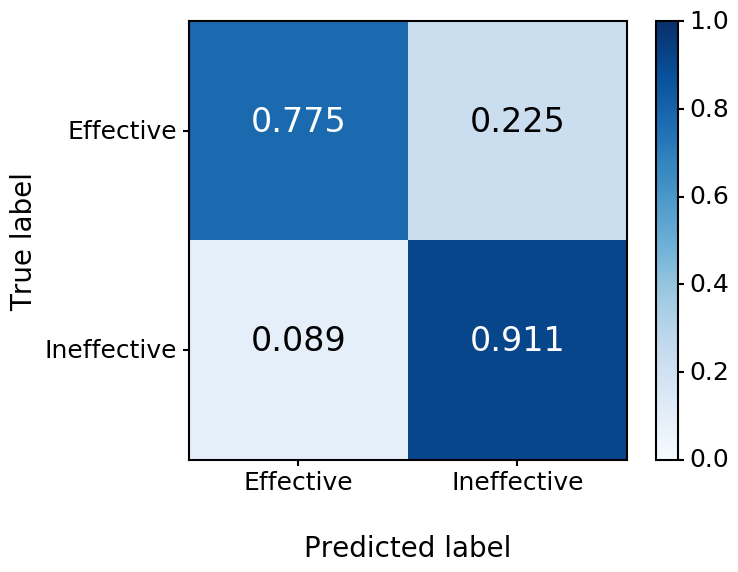

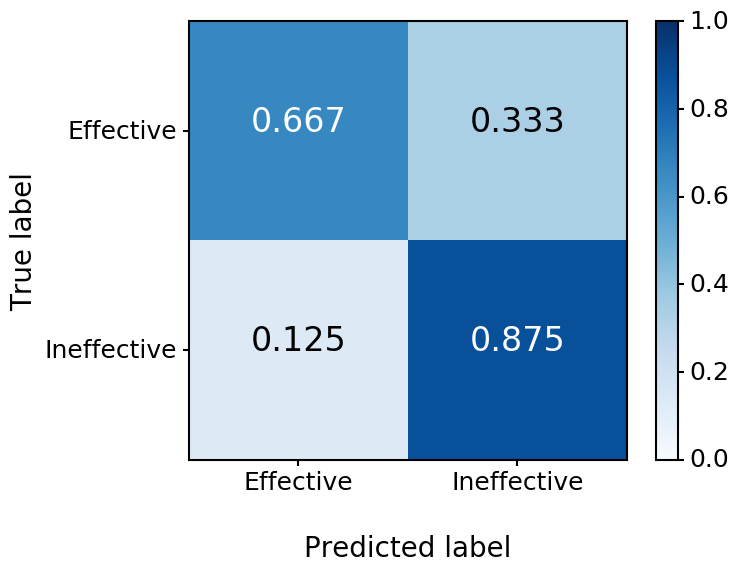

('train: ', 0.85416666666666663)
('test: ', 0.81818181818181823)


In [15]:
chosen = {'max_features': 1, 'min_samples_split': 2, 'n_estimators': 75, 'max_depth': 4}
regr = RandomForestClassifier(random_state=200, class_weight='balanced',
                               **chosen)
regr.fit(X_train, y_train)

pred_train = regr.predict(X_train)
pred_test = regr.predict(X_test)

train_matrix = metrics.confusion_matrix(y_train, pred_train)
test_matrix = metrics.confusion_matrix(y_test, pred_test)

my_plot_confusion_matrix(train_matrix, classes=['Ineffective', 'Effective'],
                      title='train', normalize=True, invert=True)

my_plot_confusion_matrix(test_matrix, classes=['Ineffective', 'Effective'],
                      title='test', normalize=True, invert=True)
print( 'train: ', metrics.accuracy_score(np.array(train['hypot_score']), pred_train))
print('test: ', metrics.accuracy_score(np.array(test['hypot_score']), pred_test))

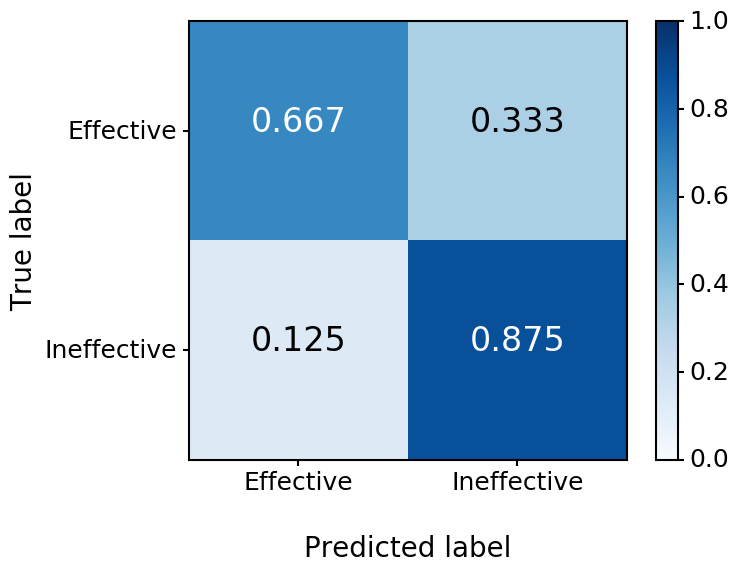

In [16]:
my_plot_confusion_matrix(test_matrix, classes=['Ineffective', 'Effective'],
                      title='test', normalize=True, invert=True, filename='RandF_Confusion.png')

In [17]:
translate_dict = {'patient_age': 'Age', 'beta_blocker': 'Beta blockers',
                  'CAD': 'Heart disease', 'aspirin': 'Aspirin', 'OBESE': 'Obesity',
                  'nitrate': 'Nitrate', 'ACE_inhibitor': 'ACE inhibitors', 
                  'DIABETES': 'Diabetes', 'ever_smoked': 'Smoker status',
                  'is_male': 'Sex', 'statin': 'Statin', 'metformin': 'Metformin',
                  'calcium_channel_blocker': 'Ca channel blockers',
                  'insulin': 'Insulin', 'sulfonylureas': 'Sulfonylureas',
                  'HYPERLIPIDEMIA': 'High cholesterol', 'diuretic': 'Diuretic',
                  'ARB':'ARB', 'thienopyridine': 'Thienopyridine',
                  'thiazolidinedione': 'Thiazolidinedione'}
#ARB = Angiotensin receptor blockers

group_dict = {'patient_age': 'demo', 'beta_blocker': 'bp',
                  'CAD': 'diag', 'aspirin': 'non', 'OBESE': 'diag',
                  'nitrate': 'bp', 'ACE_inhibitor': 'bp', 
                  'DIABETES': 'diag', 'ever_smoked': 'demo',
                  'is_male': 'demo', 'statin': 'non', 'metformin': 'non',
                  'calcium_channel_blocker': 'bp',
                  'insulin': 'non', 'sulfonylureas': 'non',
                  'HYPERLIPIDEMIA': 'diag', 'diuretic': 'bp',
                  'ARB':'bp', 'thienopyridine': 'non',
                  'thiazolidinedione': 'non'}

Index([u'patient_age', u'CAD', u'ACE_inhibitor', u'ever_smoked', u'OBESE',
       u'HYPERLIPIDEMIA', u'sulfonylureas', u'beta_blocker', u'metformin',
       u'aspirin', u'DIABETES', u'nitrate', u'diuretic', u'is_male', u'ARB',
       u'calcium_channel_blocker', u'statin', u'thienopyridine', u'insulin',
       u'thiazolidinedione'],
      dtype='object')


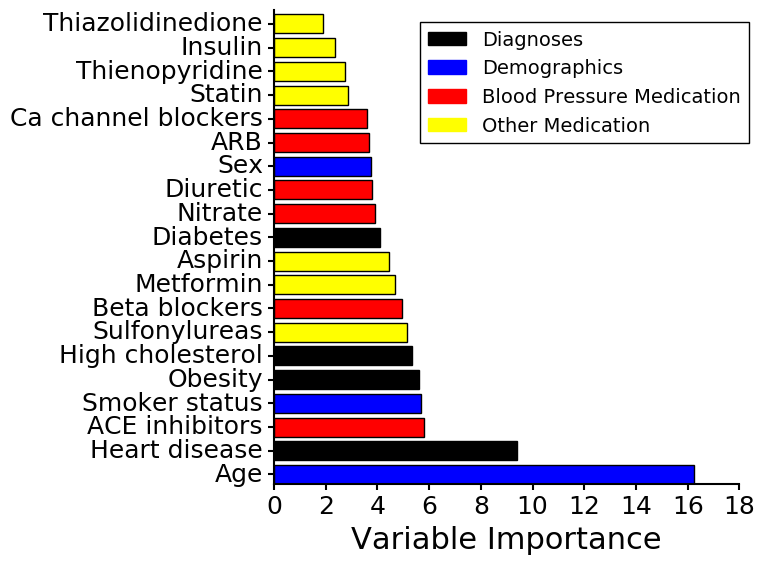

In [18]:
axt = plt.gca()
for axis in ['top','right']:
    axt.tick_params(**{axis:False})
    
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X_train.columns).sort_values(inplace=False, ascending=False)
print(rel_imp.index)

names = [translate_dict[x] for x in rel_imp.index]

color_dict = {'diag': 'black', 'demo': 'blue',
              'bp': 'red', 'non': 'yellow'}

colors = [color_dict[group_dict[x]] for x in rel_imp.index]

plt.barh(range(0, len(names)), rel_imp.tolist(), color=colors)
plt.yticks([x+0.4 for x in range(0, len(names))], names, fontsize=18)
plt.xlabel('Variable Importance', fontsize=22)
plt.gca().legend_ = None
p1 = mpatches.Patch(color=color_dict['diag'], label='Diagnoses')
p2 = mpatches.Patch(color=color_dict['demo'], label='Demographics')
p3 = mpatches.Patch(color=color_dict['bp'], label='Blood Pressure Medication')
p4 = mpatches.Patch(color=color_dict['non'], label='Other Medication')
plt.legend(handles=[p1,p2,p3,p4], fontsize=14, 
           bbox_to_anchor=(0.97, 0.95),
           bbox_transform=plt.gcf().transFigure)

plt.tight_layout()
plt.savefig('RandF_importance.png')
plt.show()

Index([u'patient_age', u'CAD', u'ACE_inhibitor', u'ever_smoked', u'OBESE',
       u'HYPERLIPIDEMIA', u'sulfonylureas', u'beta_blocker', u'metformin',
       u'aspirin'],
      dtype='object')


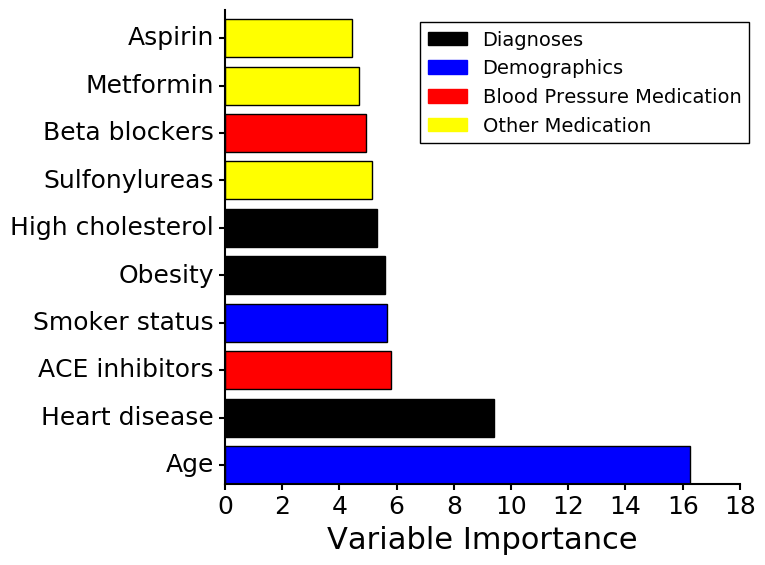

In [19]:
axt = plt.gca()
for axis in ['top','right']:
    axt.tick_params(**{axis:False})
    
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X_train.columns).sort_values(inplace=False, ascending=False)
rel_imp = rel_imp[:10]
print(rel_imp.index)

names = [translate_dict[x] for x in rel_imp.index]

color_dict = {'diag': 'black', 'demo': 'blue',
              'bp': 'red', 'non': 'yellow'}

colors = [color_dict[group_dict[x]] for x in rel_imp.index]

plt.barh(range(0, len(names)), rel_imp.tolist(), color=colors)
plt.yticks([x+0.4 for x in range(0, len(names))], names, fontsize=18)
plt.xlabel('Variable Importance', fontsize=22)
plt.gca().legend_ = None
p1 = mpatches.Patch(color=color_dict['diag'], label='Diagnoses')
p2 = mpatches.Patch(color=color_dict['demo'], label='Demographics')
p3 = mpatches.Patch(color=color_dict['bp'], label='Blood Pressure Medication')
p4 = mpatches.Patch(color=color_dict['non'], label='Other Medication')
plt.legend(handles=[p1,p2,p3,p4], fontsize=14, 
           bbox_to_anchor=(0.97, 0.95),
           bbox_transform=plt.gcf().transFigure)

plt.tight_layout()
plt.savefig('RandF_importance_top10.png')
plt.show()

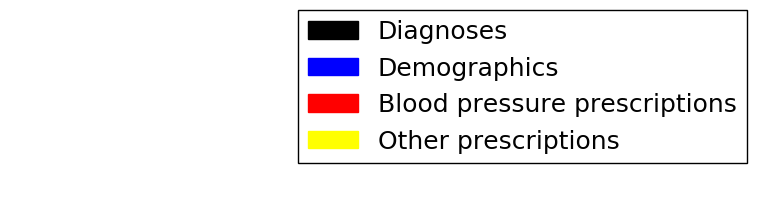

In [22]:
plt.figure(figsize=(8, 2.5))
plt.axis('off')


p1 = mpatches.Patch(color=color_dict['diag'], label='Diagnoses')
p2 = mpatches.Patch(color=color_dict['demo'], label='Demographics')
p3 = mpatches.Patch(color=color_dict['bp'], label='Blood pressure prescriptions')
p4 = mpatches.Patch(color=color_dict['non'], label='Other prescriptions')
plt.legend(handles=[p1,p2,p3,p4], fontsize=18, 
           bbox_to_anchor=(0.97, 0.95),
           bbox_transform=plt.gcf().transFigure)

plt.tight_layout()

plt.savefig('important_legend.png')

plt.show()

In [23]:
fam = Binomial()
ind = Independence()
formula = '+'.join(these_factors)
model1 = GEE.from_formula("hypot_score ~ {} ".format(formula), "patient_id", train, cov_struct=ind, family=fam)
result1 = model1.fit()
print(result1.summary())

predicted_train = np.array([round(x) for x in result1.predict(train[these_factors])])
predicted_test = np.array([round(x) for x in result1.predict(test[these_factors])])
train_score = metrics.accuracy_score(np.array(train['hypot_score']), predicted_train)
test_score = metrics.accuracy_score(np.array(test['hypot_score']), predicted_test)
print(train_score, test_score)

                               GEE Regression Results                              
Dep. Variable:                 hypot_score   No. Observations:                   96
Model:                                 GEE   No. clusters:                       54
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   4
Family:                           Binomial   Mean cluster size:                 1.8
Dependence structure:         Independence   Num. iterations:                     6
Date:                     Fri, 17 Feb 2017   Scale:                           1.250
Covariance type:                    robust   Time:                         12:24:49
                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                   2.6926      1.616      1.666    

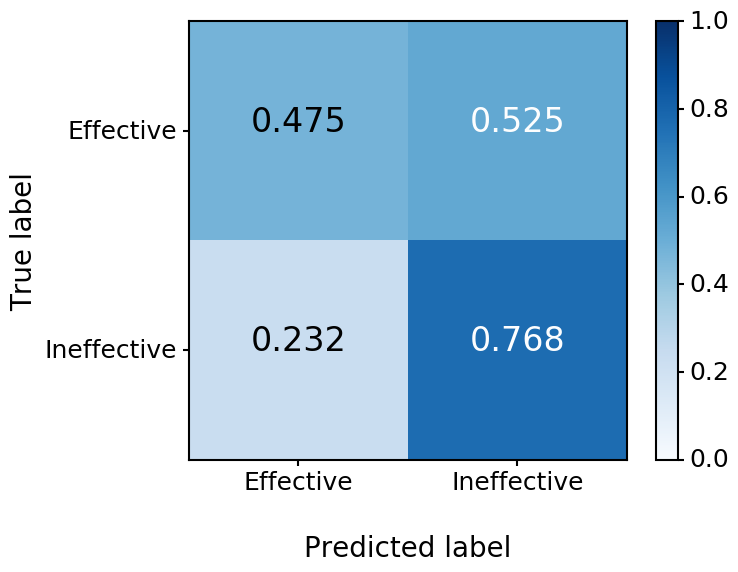

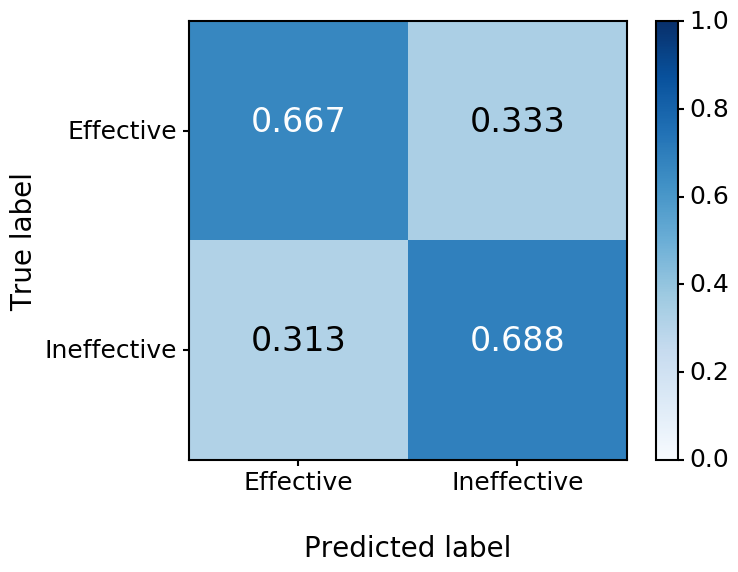

('train: ', 0.64583333333333337)
('test: ', 0.68181818181818177)


In [24]:
pred_train = [round(x) for x in result1.predict(train[these_factors])]
pred_test = [round(x) for x in result1.predict(test[these_factors])]

train_matrix = metrics.confusion_matrix(train['hypot_score'], pred_train)
test_matrix = metrics.confusion_matrix(test['hypot_score'], pred_test)

my_plot_confusion_matrix(train_matrix, classes=['Ineffective', 'Effective'],
                      title='train', normalize=True, invert=True)

my_plot_confusion_matrix(test_matrix, classes=['Ineffective', 'Effective'],
                      title='test', normalize=True, invert=True,
                        filename='Log_confusion.png')
print( 'train: ', metrics.accuracy_score(np.array(train['hypot_score']), pred_train))
print('test: ', metrics.accuracy_score(np.array(test['hypot_score']), pred_test))

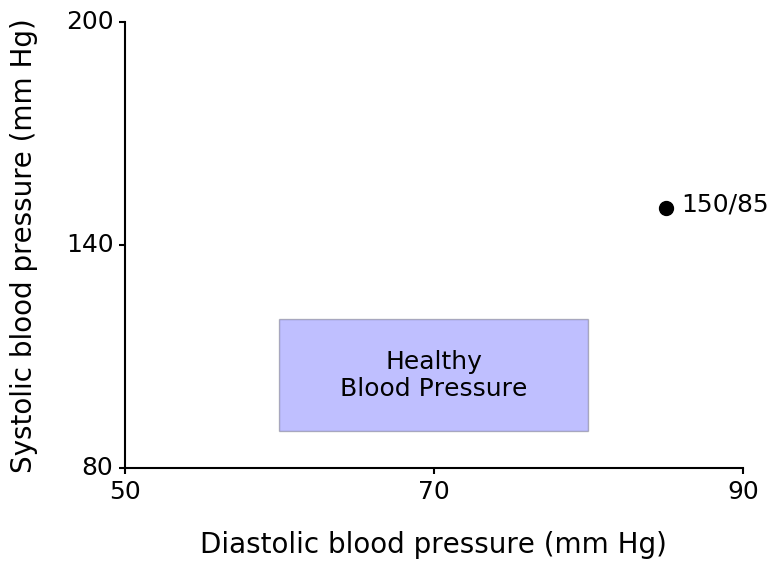

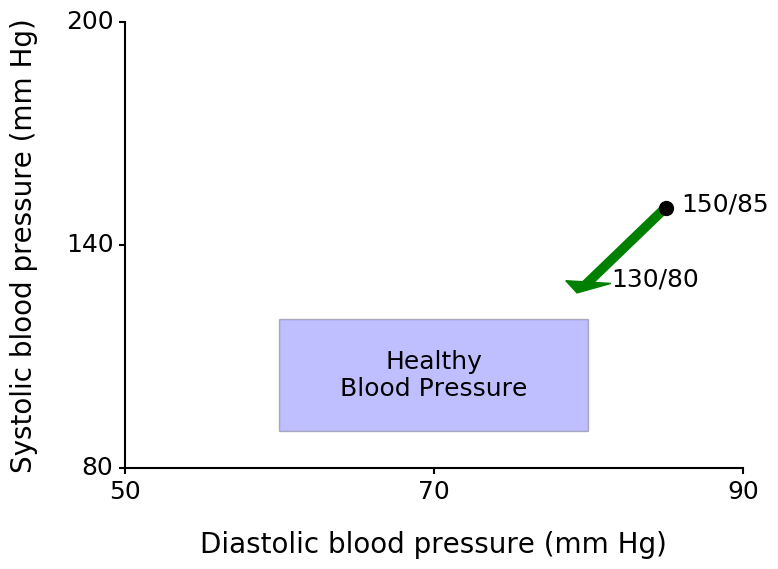

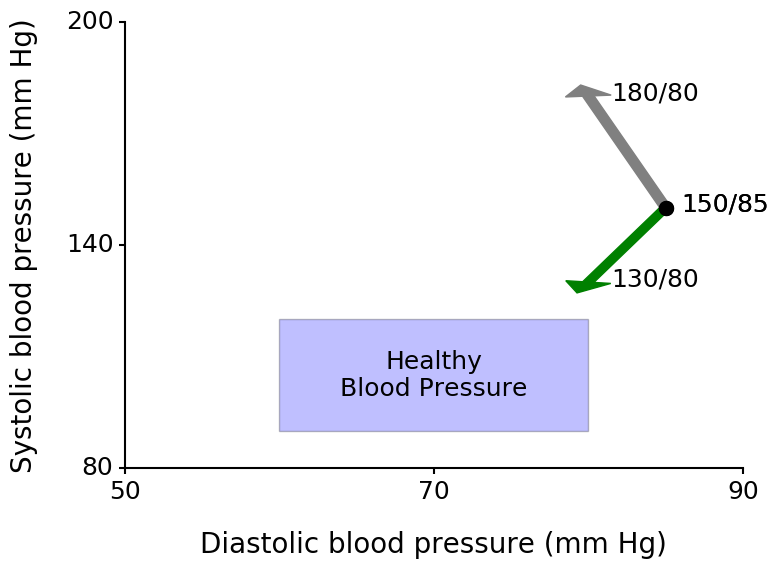

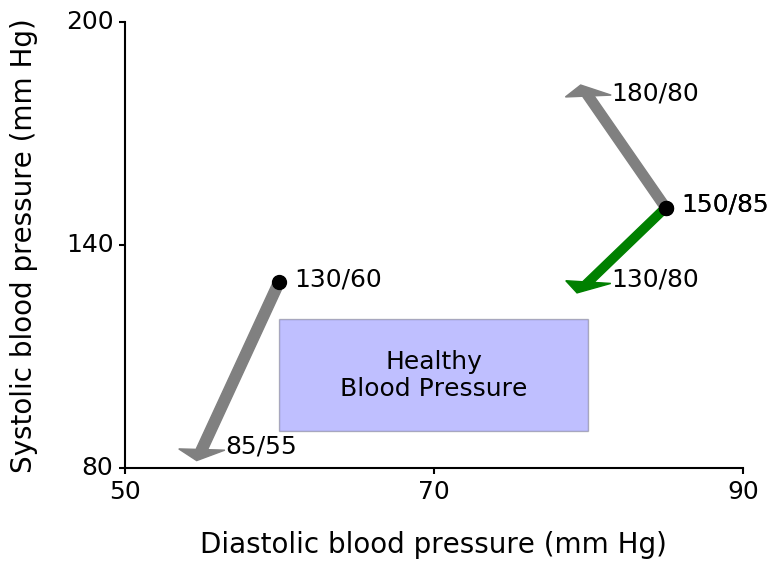

In [25]:
person1_start = (150, 85)
person1_end = (130, 80)
person2_start = person1_start
person2_end = (180, 80)
person3_start = (130, 60)
person3_end = (85, 55)
arrow_params = {'head_width':3, 'head_length':3, 'width':0.75}

for pic_num in [1, 2, 3, 4]:
    # Hide the right and top ticks
    axt = plt.gca()
    for axis in ['top','right']:
        axt.tick_params(**{axis:False})

    plt.ylabel('Systolic blood pressure (mm Hg)', fontsize=20, labelpad=20)
    plt.xlabel('Diastolic blood pressure (mm Hg)', fontsize=20, labelpad=20)



    axt.add_patch(mpatches.Rectangle((60, 90), 20, 30, fill='navyblue', alpha=0.25))
    plt.text(70, 105, 'Healthy\nBlood Pressure', ha='center', va='center')

    plt.ylim(ymin=80, ymax=200)
    axt.yaxis.set_ticks([80, 140, 200])
    plt.xlim(xmin=50, xmax=90)
    axt.xaxis.set_ticks([50, 70, 90])

    value_dict= {1:([person1_start], [person1_end]),
                 2:([person1_start], [person1_end]),
                 3:([person1_start, person2_start], [person1_end, person2_end]),
                 4:([person1_start, person2_start, person3_start], [person1_end, person2_end, person3_end])
                }

    start_values, end_values = value_dict[pic_num]

    plt.scatter(y=[s for s,d in start_values], x=[d for s,d in start_values],
             marker='o',edgecolor='k', 
                facecolor='k', s=100, zorder=2)
    sys_fuzz = -1
    dia_fuzz = +1

    for sys, dia in start_values:
        axt.annotate(s='{}/{}'.format(sys,dia), xy=(dia+dia_fuzz, sys+sys_fuzz))
    #plt.text(s=['{}/{}'.format(s,d) for s,d in start_values], y=[s for s,d in start_values], x=[d for s,d in start_values],)
    if pic_num > 1:
        for first, second, color in zip(start_values, end_values, ['green', 'gray', 'gray']):
            axt.arrow(first[1], first[0], (second[1] - first[1]), (second[0]-first[0]), 
                      fc= color, ec=color, label="k", zorder=1,
                     **arrow_params)
        for sys, dia in end_values:
            axt.annotate(s='{}/{}'.format(sys,dia), xy=(dia+dia_fuzz+0.5, sys+sys_fuzz))
    plt.tight_layout()
    plt.savefig('healthy_{}.png'.format(pic_num))
    plt.show()

In [27]:
def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):

    p = mpatches.FancyArrow(width, 0.5*height, -1 * width, 0, length_includes_head=True, head_width=0.75*height, width=3)
    return p

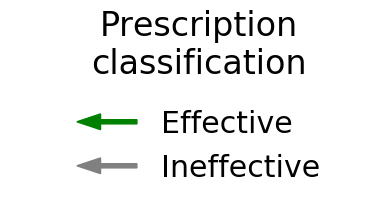

In [29]:
plt.figure(figsize=(4, 2.5))
plt.axis('off')


plt.title('Prescription\nclassification\n', fontsize=24)
green_arrow = axt.arrow(0, 0, 0, 0, color='green', **arrow_params)
gray_arrow = axt.arrow(0, 0, 0, 0, color='gray', **arrow_params)

plt.legend([green_arrow, gray_arrow], ['Effective' ,'Ineffective'], 
           handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},
          loc='center', frameon=False)
plt.tight_layout()
plt.savefig('healthy_legend.png'.format(pic_num))

plt.show()

In [30]:
empty_person = pd.DataFrame(columns= X_train.columns, index=[0], data=np.nan)
print(empty_person.columns)
empty_person.head()

Index([u'patient_age', u'is_male', u'ever_smoked', u'ACE_inhibitor', u'ARB',
       u'aspirin', u'beta_blocker', u'calcium_channel_blocker', u'diuretic',
       u'insulin', u'metformin', u'nitrate', u'statin', u'sulfonylureas',
       u'thiazolidinedione', u'thienopyridine', u'CAD', u'DIABETES',
       u'HYPERLIPIDEMIA', u'OBESE'],
      dtype='object')


,patient_age,is_male,ever_smoked,ACE_inhibitor,ARB,aspirin,beta_blocker,calcium_channel_blocker,diuretic,insulin,metformin,nitrate,statin,sulfonylureas,thiazolidinedione,thienopyridine,CAD,DIABETES,HYPERLIPIDEMIA,OBESE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
empty_person.to_pickle('empty_person.pkl')

from sklearn.externals import joblib
joblib.dump(regr, 'my_model.pkl') 

['my_model.pkl']

In [32]:
def compute_weight(med_count):
    return round((med_count - 1.) * 0.05, 2)
def compute_weighted_score(pred_num, med_count):
    try:
        result_list = []
        for each_pred, each_count in zip(pred_num, med_count):
            result_list.append(compute_weighted_score(each_pred, each_count))
        return result_list
    except TypeError:
        weight = compute_weight(med_count)
        return (pred_num * (1 - weight)) - (weight)

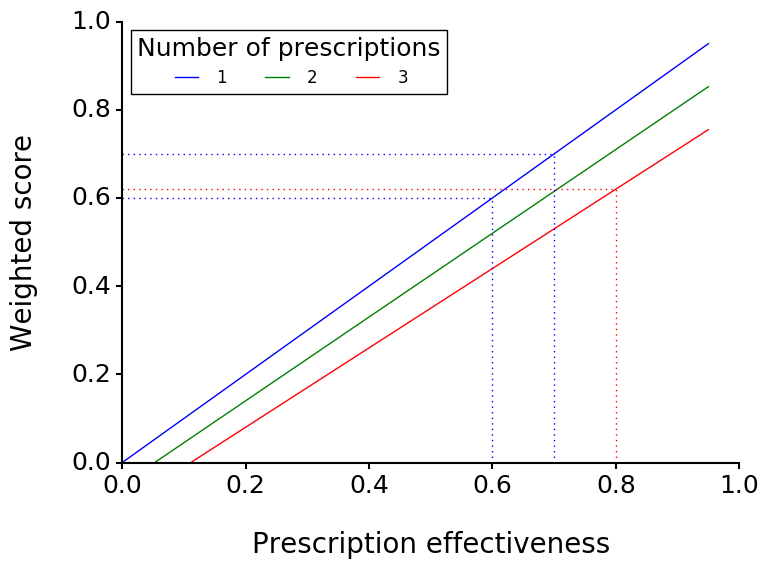

In [33]:
axt = plt.gca()
for axis in ['top','right']:
    axt.tick_params(**{axis:False})

pred_scores = [x/ 100. for x in xrange(0, 100, 5)]

for med_num in [1, 2, 3]:
    y_vals = compute_weighted_score(pred_scores, [med_num for __ in range(len(pred_scores))])
    plt.plot(pred_scores, y_vals, label=med_num)
plt.ylabel('Weighted score', fontsize=20, labelpad=24)
plt.xlabel('Prescription effectiveness', fontsize=20, labelpad=24)
plt.legend(loc=2, title='Number of prescriptions', ncol=3, fontsize=12)
plt.xlim(xmin=0, xmax=1)
plt.ylim(ymin=0, ymax=1)

for pred, num, col in [(0.7,1,'blue'), (0.8,3,'red'), (0.6,1,'blue')]:
    y1 = compute_weighted_score(pred, num)
    plt.plot([pred, pred], [0, y1], color=col, linestyle='dotted')
    plt.plot([0, pred], [y1, y1], color=col, linestyle='dotted')
plt.tight_layout()
plt.savefig('WeightedScores.png')
plt.show()